# Multiple Type Experiment

In [1]:
import warnings;
warnings.filterwarnings('ignore');

from time import sleep
from tqdm.auto import tqdm

import sys
import importlib
import numpy as np
import nbformat
# import plotly.express
# import plotly.express as px
import pandas as pd
import cvxpy as cp
import scipy.optimize as optimization
import matplotlib.pyplot as plt
import seaborn as sns

### Confidence Scaling

In [3]:
cup = 3
clow = 3

### CVXPY Code

In [3]:
def generate_cvxpy_solve(num_types, num_resources):
    x = cp.Variable(shape=(num_types,num_resources))

    sizes = cp.Parameter(num_types, nonneg=True)
    weights = cp.Parameter((num_types, num_resources), nonneg=True)
    budget = cp.Parameter(num_resources, nonneg=True)


    objective = cp.Maximize(cp.log(cp.sum(cp.multiply(x, weights), axis=1)) @ sizes)


    constraints = []
    constraints += [0 <= x]
    for i in range(num_resources):
        constraints += [x[:, i] @ sizes <= budget[i]]
    # constraints += [x @ sizes <= budget]

    prob = cp.Problem(objective, constraints)
    
    def solver(true_sizes, true_weights, true_budget, constraints):
        sizes.value = true_sizes
        weights.value = true_weights
        budget.value = true_budget
        
        prob.solve(solver=cp.MOSEK)
        
        return prob.value, np.around(x.value, 5), constraints
    
    return prob, solver, constraints

### Simple Test

In [4]:
prob, solver, constraints = generate_cvxpy_solve(2, 2)

val, sol, cons = solver(np.asarray([1., 1.]), np.asarray([[1,1],[1,1]]), np.asarray([1,1]), constraints)
print(cons[1].dual_value)

val, sol, cons = solver(np.asarray([1., 2.]), np.asarray([[1,1],[1,1]]), np.asarray([1,1]), constraints)
print(cons[1].dual_value)


1.0000057873230548
1.4999178359988916


In [5]:
prob, solver, constraints = generate_cvxpy_solve(5,3)

### Sensitivity of EG Program

Calculating difference in allocations for: 0.01
Sizes: ([2.0, 3.0], [2.0, 3.01], [2.0, 2.98])
1.1110659226888386 0.8888527386259493 2.999962878821536
1.1110635144225542 0.8888508120719286 3.0099618170262246
1.1110697732732142 0.8888558190082515 2.979964967443501
Testing Prices Monotonicity
[False False  True]
[False False  True]
Calculating difference in allocations for: 0.05
Sizes: ([2.0, 3.0], [2.0, 3.05], [2.0, 2.9])
1.1110659226888386 0.8888527386259493 2.999962878821536
1.1110540437200935 0.888843235771872 3.049958154085502
1.111074536338191 0.8888596293704043 2.8999723203510883
Testing Prices Monotonicity
[False False  True]
[False False  True]
Calculating difference in allocations for: 0.1
Sizes: ([2.0, 3.0], [2.0, 3.1], [2.0, 2.8])
1.1110659226888386 0.8888527386259493 2.999962878821536
1.1110402202265806 0.888832177438534 3.0999537991618396
1.1110993590745493 0.8888794872466043 2.799966378377406
Testing Prices Monotonicity
[False False  True]
[False False  True]
Calculating di

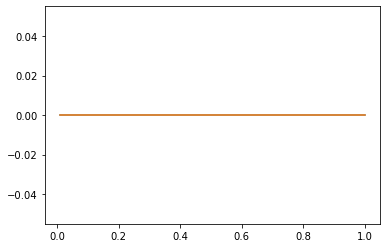

In [11]:
eps = 0.05

# delta_list = [.5, .2, .1]

delta_list = [.01, 0.05, .1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, .5, 1.]

y1 = np.zeros(len(delta_list))
y2 = np.zeros(len(delta_list))

prob, solver, cons = generate_cvxpy_solve(2, 3)
# true_weights = np.asarray([[1.5, .4, 2],[3, 2.6, .5]])

true_weights = np.asarray([[5, 4, 2], [3, 2, 10]])

# true_weights = np.asarray([[1,1,1],[1,1,1]])
true_budget = [1., 1., 1.]


index = 0
for delta in delta_list:
    print('Calculating difference in allocations for: ' + str(delta))
    sizes_1 = [2., 3.]
    sizes_2 = [2., 3.+delta]
    sizes_3 = [2., 3.-2*delta]
    
    print('Sizes: ' + str((sizes_1, sizes_2, sizes_3)))
          
    v1, x_1, c_1 = solver(sizes_1, true_weights, true_budget, cons)
    print(c_1[1].dual_value, c_1[2].dual_value, c_1[3].dual_value)
    d_1 = [c_1[1].dual_value, c_1[2].dual_value, c_1[3].dual_value]
    v2, x_2, c_2 = solver(sizes_2, true_weights, true_budget, cons)
    print(c_2[1].dual_value, c_2[2].dual_value, c_2[3].dual_value)
    d_2 = [c_2[1].dual_value, c_2[2].dual_value, c_2[3].dual_value]
    v3, x_3, c_3 = solver(sizes_3, true_weights, true_budget, cons)
    print(c_3[1].dual_value, c_3[2].dual_value, c_3[3].dual_value)
    d_3 = [c_3[1].dual_value, c_3[2].dual_value, c_3[3].dual_value]
    
#     x_1 = np.around(x_1, 5)
#     x_2 = np.around(x_2, 3)
#     x_3 = np.around(x_3, 5)
    
#     print('Solutions: ')
#     print('Orig: ' + str(x_1))
#     print('Plus Delta: ' + str(x_2))
#     print('Minus Delta: ' + str(x_3))
# #     print('Scaling Check: ' + str(np.around(x_1 / (1+delta),3) == np.around(x_2,3)))
# #     print('Scaling Check (2): ' + str(np.around(x_1 / (1-delta),3) == np.around(x_3,3)))


#     print('Objective Values: ' + str((v1, v2, v3)))
    
#     print('Testing Budget Constraint: ')
#     print(np.around(sizes_3 @ x_3,1) <= np.around(true_budget,1))
    
#     print('Testing Dual Price Constraint: ')
#     print(np.around(np.matmul(x_1, d_1), 3) == [1., 1.])
#     print(np.around(np.matmul(x_2, d_2), 3) == [1., 1.])
#     print(np.around(np.matmul(x_3, d_3), 3) == [1., 1.])
    
#     print('Testing Monotonicity:')
#     print(x_1 >= x_2)
#     print(x_1 <= x_3)
#     y1[index] = np.max(np.abs(x_1 - x_2))
#     y2[index] = np.max(np.abs(x_1 - x_3))
    
    print('Testing Prices Monotonicity')
    print(np.greater(np.around(d_2, 4), np.around(d_1, 4)))
    print(np.greater(np.around(d_1, 4), np.around(d_3, 4)))
    
    
    index += 1
    
print(delta_list, y1, y2)
plt.plot(delta_list, y1)
plt.plot(delta_list, y2)

array([1., 1.])

array([ True,  True,  True])

### Offline Optimal Solution

In [7]:
def offline_opt(budget, size, mean, weights, solver):
    tot_size = np.sum(size, axis=0)
    _, x = solver(tot_size, weights, budget)
    allocation = np.zeros((size.shape[0], weights.shape[0], weights.shape[1]))
    for i in range(size.shape[0]):
        allocation[i,:,:] = x
    return allocation

### Threshold Based Algorithms

In [8]:
def fixed_threshold(budget, size, mean, weights, solver):
    
    num_locations = size.shape[0]
    num_types = weights.shape[0]
    num_resources = weights.shape[1]
    
    allocation = np.zeros((n, num_types, num_resources))
    budget_remaining = budget


#     tot_mean_size = size[0] + np.sum(mean[1:], axis=0) + clow*np.sqrt(num_locations * np.log(num_locations))
    
    future_size = size[0] + np.sum(mean[1:], axis=0)
    conf_bnd = clow*np.sqrt(num_locations * np.log(num_locations))
    tot_mean_size = future_size*(1 + conf_bnd / np.min(future_size))
    
    
    
    # np.sum(mean)(1 + (sqrt / min(sum(mean)))
    
    _, lower_thresh = solver(tot_mean_size, weights, budget)


    for i in range(n):

        if np.min(budget_remaining - np.matmul(size[i,:], lower_thresh)) > 0:
            allocation[i,:,:] = lower_thresh
        else:
            print('Fixed: Out of budget!')
            allocation[i, :, :] = np.array([budget_remaining / np.sum(size[i,:]),]*num_types)

        budget_remaining -= np.matmul(size[i, :], allocation[i])
    
    
    return allocation, budget_remaining

In [9]:
def adapt_init_threshold(budget, size, mean, weights, solver):
    
    num_locations = size.shape[0]
    num_types = weights.shape[0]
    num_resources = weights.shape[1]
    
    allocation = np.zeros((n, num_types, num_resources))
    budget_remaining = budget

    
    future_size = size[0] + np.sum(mean[1:], axis=0)
    conf_bnd = clow*np.sqrt(num_locations * np.log(num_locations))
    tot_low_mean_size = future_size*(1 + conf_bnd / np.min(future_size))
    tot_up_mean_size = np.maximum(1, future_size*(1 - conf_bnd / np.min(future_size)))
    # print(tot_low_mean_size, tot_up_mean_size)
    
    
    # np.sum(mean)(1 + (sqrt / min(sum(mean)))
    
    _, lower_thresh = solver(tot_low_mean_size, weights, budget)
    _, upper_thresh = solver(tot_up_mean_size, weights, budget)

    for i in range(n):
        rem = n - i
        budget_required = budget_remaining - np.matmul(size[i, :], upper_thresh) - np.matmul(np.sum(mean[(i+1):], axis=0) + clow*np.sqrt(rem*np.log(rem)), lower_thresh)

        if np.min(budget_remaining - np.matmul(size[i,:], upper_thresh)) > 0 and np.min(budget_required) > 0:
            print('Allocating upper threshold')
            allocation[i,:,:] = upper_thresh
        elif np.min(budget_remaining - np.matmul(size[i,:], lower_thresh)) > 0:
            allocation[i,:,:] = lower_thresh
        else:
            print('Adapt: Out of budget!')
            allocation[i, :, :] = np.array([budget_remaining / np.sum(size[i,:]),]*num_types)

        budget_remaining -= np.matmul(size[i, :], allocation[i])
    
    return allocation, budget_remaining

### Scaling with n

In [10]:
#np.random.choice(size=5, a=[1.,2.], p=[1/2, 1/2])
1+np.random.poisson(size=5,lam = 1.5)

array([2, 1, 3, 3, 4])

In [11]:
data = []
num_types = 5
num_resources = 3
weights = np.asarray([[1, 2, 3], [1, 3, 2], [4, 1, 5], [1, 2, .5], [3, 7, 5]])
sum_of_rows = weights.sum(axis=1)
weights = weights / sum_of_rows[:, np.newaxis]

# algo_list = [adapt_init_threshold_new_cb, adapt_threshold, adapt_init_threshold, sid_threshold, adapt_init_under_over_threshold, fixed_threshold]
algo_list = [fixed_threshold,adapt_init_threshold]
# algo_list = [fixed_threshold]


num_iterations = 5
max_n = 100

mean_size = np.asarray([1, 3, 6, 2, 5])
# dist_weights = [1/5, 1/5, 1/5, 1/5, 1/5]

for n in tqdm(np.arange(2,max_n+1)):
    print('Num Locations: ' + str(n))
    # pected_size = mean_size
    budget = [n, n, n]
    
    mean = np.array([mean_size,]*n)
    # print(mean)
    for i in range(num_iterations):
        # size = np.random.choice(size=(n, num_types), a=[1.,2.], p=[1/2, 1/2])
        size = 1+np.random.poisson(size=(n, num_types), lam = mean_size)
        # print('Size: ' + str(size))
        total_num_types = np.sum(size, axis=0)
        
        prob, solver = generate_cvxpy_solve(num_types, num_resources)

        
        # print(num_types, num_resources, budget.shape size.shape, )
        
        opt = offline_opt(budget, size, mean, weights, solver)
        
        # print('opt: ' + str(opt))
        for algo in algo_list:
            sol, waste = algo(budget, size, mean, weights, solver)
            
            # print('Algo: ' + str(sol))
            # print('Opt: ' + str(opt))
            
            data_dict = {'NumGroups': n, 'Algorithm':algo.__name__, 'Norm': 'L1', 'Value': np.sum(np.abs(opt-sol))}
            data.append(data_dict)
            data_dict = {'NumGroups': n, 'Algorithm':algo.__name__, 'Norm': 'Linf', 'Value': np.max(np.abs(opt-sol))}
            data.append(data_dict)
            data_dict = {'NumGroups': n, 'Algorithm':algo.__name__, 'Norm': 'Waste', 'Value': np.sum(waste) / n}
            data.append(data_dict)
        
    sleep(0)

  0%|          | 0/99 [00:00<?, ?it/s]

Num Locations: 2


ValueError: too many values to unpack (expected 2)

In [ ]:
df = pd.DataFrame.from_records(data)
df.columns


#filled_markers = ('o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X')
#plt.figure(figsize=(20,10))
#plt.title('Simple Distribution L1')
#sns.lineplot(x='NumGroups', y='value', hue='variable', data=df[df.Norm == 'L1'])

filled_markers = ('o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X')
plt.figure(figsize=(16,8))
plt.title('Simple Distribution LInf')
sns.lineplot(x='NumGroups', y='Value', hue='Algorithm', data=df[df.Norm == 'Linf'], ci=None)


filled_markers = ('o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X')
plt.figure(figsize=(16,8))
plt.title('Simple Distribution Waste')
sns.lineplot(x='NumGroups', y='Value', hue='Algorithm', data=df[df.Norm == 'Waste'], ci=None)


### Group by Group Difference

In [ ]:
data = []
fair_data = []
num_types = 5
num_resources = 3
weights = np.asarray([[1, 2, 3], [1, 3, 2], [4, 1, 5], [1, 2, .5], [3, 7, 5]])
sum_of_rows = weights.sum(axis=1)
weights = weights / sum_of_rows[:, np.newaxis]

# algo_list = [adapt_init_threshold_new_cb, adapt_threshold, adapt_init_threshold, sid_threshold, adapt_init_under_over_threshold, fixed_threshold]
algo_list = [fixed_threshold,adapt_init_threshold]

num_iterations = 20
n = 100

mean_size = np.asarray([1, 3, 6, 2, 5])



for i in tqdm(range(num_iterations)):
    budget = [n, n, n]
    
    mean = np.array([mean_size,]*n)
    # print(mean)

    # size = np.random.choice(size=n, a=[1.,2.], p=[1/2, 1/2])
    size = 1+np.random.poisson(size=(n, num_types), lam = mean_size)
    # print('Size: ' + str(size))
    total_num_types = np.sum(size, axis=0)

    prob, solver = generate_cvxpy_solve(num_types, num_resources)


    # print(num_types, num_resources, budget.shape size.shape, )

    opt = offline_opt(budget, size, mean, weights, solver)

    # print('opt: ' + str(opt))
    for algo in algo_list:
        sol, waste = algo(budget, size, mean, weights, solver)
        
        prop_alloc = budget / np.sum(size)   
        envy = 0
        proportional = 0
        
        
        for j in range(n):
            data.append({'Location':j, 'Algorithm':algo.__name__, 'Value': np.max(opt[j] - sol[j])})
            for k in range(num_types):
                proportional = max(proportional, np.dot(weights[k,:], prop_alloc) - np.dot(weights[k,:], sol[j,k,:]))
        
        for j1 in range(n):
            for j2 in range(n):
                for k1 in range(num_types):
                    for k2 in range(num_types):
                        # how much envy do people of type k1 in location j1 have for people of type k2 in location j2
                        envy = max(envy, np.dot(weights[k1,:], sol[j2, k2, :]) - np.dot(weights[k1,:], sol[j1, k1, :]))
            
        
        fair_data.append({'Iteration':i, 'Algorithm':algo.__name__, 'Waste':np.sum(waste) / n, 'Envy':envy, 'Proportional':proportional})
            
for i in range(n):
    data.append({'Location': i, 'Algorithm':'Zero', 'Value': 0})

In [ ]:
df = pd.DataFrame.from_records(data)

plt.figure(figsize=(20,10))
sns.lineplot(x='Location', y='Value', hue = 'Algorithm', data=df, ci = None)
plt.title('Allocation Difference')
plt.xlabel('Location')
plt.ylabel('Allocation Difference')
plt.plot()

Note: Discrepancy is between where max and average are between this plot and the other one.

### Printing Fairness Metrics

In [ ]:
fair_df = pd.DataFrame.from_records(fair_data)
print(fair_df.columns)
fair_df = fair_df.groupby(['Algorithm']).mean()
print(fair_df.drop(['Iteration'], axis=1))